Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/intro_dl/blob/master/Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!wget https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils
!pip install git+https://github.com/google/flax.git
!pip install umap-learn

--2020-08-25 17:59:04--  https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2020-08-25 17:59:04 (79.8 MB/s) - ‘colab_utils.py’ saved [7173/7173]



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-8x_fqt4w
  Running command git clone -q https://github.com/google/flax.git /tmp/pip-req-build-8x_fqt4w
  Created wheel for flax: filename=flax-0.2.0-cp36-none-any.whl size=140760 sha256=5922e7670d73af0b78124bd9db0f3cd02700f83c2af30113896a7330e75cdf01
  Stored in directory: /tmp/pip-ephem-wheel-cache-h6noppou/wheels/df/ef/29/71c694e30a038ecde1dc1ed467879fc69077cc6f81e9e777df
Successfully built flax


# MUY IMPORTANTE: USA UN GPU O TPU (choose runtime)

# Importa modulos


In [2]:
from collections import OrderedDict
import tqdm.auto as tqdm
import colab_utils

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import umap
import sklearn
# Jax
import jax
from jax import numpy as jnp, random, jit, lax
# Flax
import flax
from flax import nn, optim
# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

_ = jnp.square(2.)

colab_utils.print_module_versions([tf, tfds, jax])
colab_utils.matplotlib_settings()

tensorflow: 2.3.0
tensorflow_datasets: 2.1.0
jax       : 0.1.75


Primero lodearemos algunos datos

In [3]:
#dataset = 'fashion_mnist'
dataset_name = 'mnist'

train_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TRAIN, batch_size=-1))
x_train, y_train = train_ds['image'], train_ds['label']

test_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TEST, batch_size=-1))
x_test, y_test = test_ds['image'], test_ds['label']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


# Necesitamos DL? Primero EDA!

In [4]:
def flatten_image(x):
    return np.reshape(x, (x.shape[0],x.shape[1]*x.shape[2]))

flat_x_train = flatten_image(x_train)
flat_y_train = y_train.ravel()

flat_x_test = flatten_image(x_test)
flat_y_test = y_test.ravel()
print(flat_x_train.shape, y_train.shape)
print(flat_x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


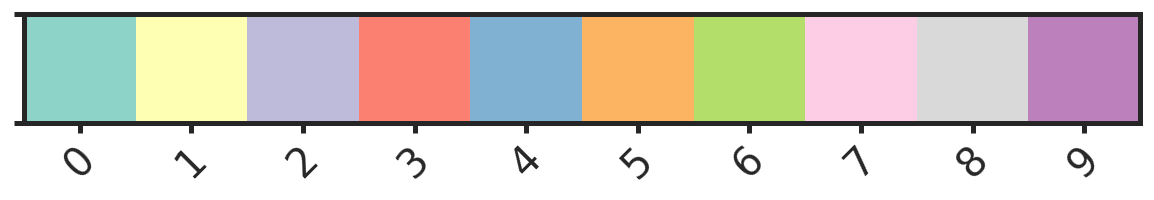

In [5]:
def labels_to_nodecolors(labels):
    """Convierte etqiuetas a colores."""
    cols = sns.color_palette("Set3", 10)
    return [cols[int(l)] for l in labels.ravel()]

def plot_color_legend(dataset_name):
    cols = sns.color_palette("Set3", 10)
    categories = {'fashion_mnist':['T-shirt/top','Trouser',
                                   'Pullover','Dress', 'Coat','Sandal',
               'Shirt','Sneaker','Bag','Ankle boot'],
               'mnist': list(range(10))}[dataset_name]
    sns.palplot(cols)
    plt.xticks(np.arange(10), categories, rotation=45)
    plt.show()
    
plot_color_legend(dataset_name)

In [15]:
import sklearn.pipeline
import sklearn.decomposition
import sklearn.preprocessing

pca_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', sklearn.decomposition.PCA(2))])

umap_pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', umap.UMAP())])

umap_pipe.fit(flat_x_train)
x_umap = umap_pipe.transform(flat_x_test)

pca_pipe.fit(flat_x_train)
x_pca = pca_pipe.transform(flat_x_test)

print(x_umap.shape, x_pca.shape)

KeyboardInterrupt: ignored

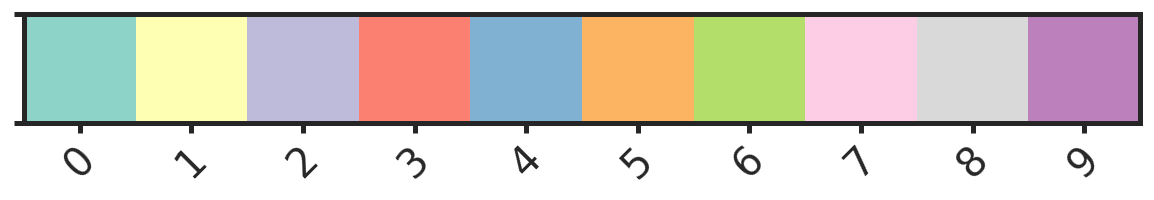

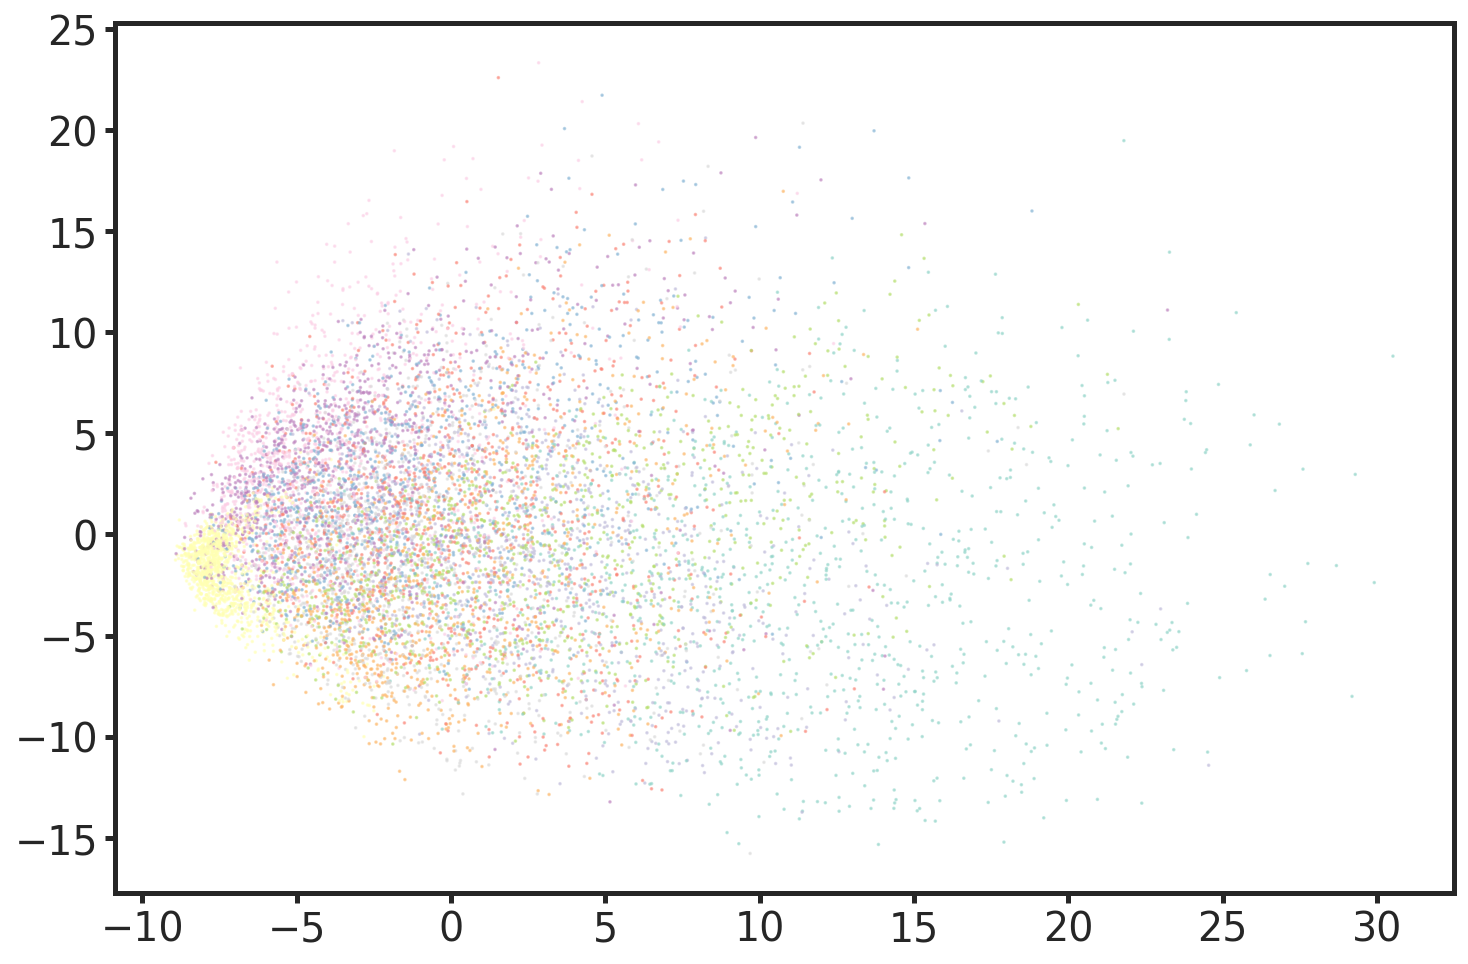

In [63]:
plot_color_legend(dataset_name)
plt.scatter(x_pca[:,0], x_pca[:, 1],
            c=labels_to_nodecolors(flat_y_test),
            s=1, alpha=0.5)
plt.show()

In [58]:
indices = np.random.permutation(len(x_umap))[:5000]

vis_df = pd.DataFrame()
vis_df['UMAP1'] = x_umap[indices, 0]
vis_df['UMAP2'] = x_umap[indices, 1]
vis_df['PC1'] = x_pca[indices, 0]
vis_df['PC2'] = x_pca[indices, 1]
vis_df['label'] = flat_y_test[indices]
vis_df

,UMAP1,UMAP2,PC1,PC2,label
0,7.885428,4.227294,0.755570,3.434424,2
1,-1.101386,3.794458,3.230337,-1.366293,8
2,-7.054633,3.163792,-8.190725,-1.709466,1
3,-1.738566,11.840984,-4.177603,5.262380,7
4,-0.456391,13.002729,-6.999848,1.495790,7
...,...,...,...,...,...
4995,7.815452,-2.205658,1.031436,4.159793,6
4996,-0.317288,4.421916,-3.303010,1.893841,8
4997,5.645652,1.568008,1.236294,-9.842185,2
4998,1.053415,3.091951,-5.267032,7.336266,3


In [64]:
alt.Chart(vis_df).mark_circle(size=10).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color='label:N',
    tooltip=['label']
).interactive()

alt.Chart(...)

## Comparativa de PCA/UMAP

In [66]:
brush = alt.selection(type='interval', resolve='global')

scatter1 = alt.Chart(vis_df).mark_circle(size=4).encode(
    x='PC1:Q',
    y='PC2:Q',
    color = alt.condition(brush, alt.Color('label:N'), alt.value('lightgray')),
    tooltip=['label']
).add_selection(brush)

scatter2 = alt.Chart(vis_df).mark_circle(size=4).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color = alt.condition(brush, alt.Color('label:N'), alt.value('lightgray')),
    tooltip=['label']
).add_selection(brush)

scatter1 | scatter2

alt.HConcatChart(...)

# Necesitamos DL? Un modelo lineal

Reloadear datos, ahora con splits

In [111]:
#train_ds = tfds.load('mnist', split=tfds.Split.TRAIN)
#train_ds = train_ds.map(lambda x: {'image': tf.cast(x['image'], tf.float32),
#                                    'label': tf.cast(x['label'], tf.int32)})
#x_train, y_train = train_ds['image'], train_ds['label']
#train_ds = train_ds.cache().shuffle(1000).batch(128)


train_ds = tfds.as_numpy(tfds.load(dataset_name, split=tfds.Split.TRAIN, batch_size=-1))
x_train, y_train = train_ds['image'], train_ds['label']

test_ds = tfds.as_numpy(tfds.load(
    'mnist', split=tfds.Split.TEST, batch_size=-1))
x_test, y_test = test_ds['image'], 


Queremos :
$$ \hat{y} = W \cdot x + b $$

Talque la diferencia $|y-\hat{y}|$ sea minima (error).

* Cuales son las dimensiones de W y b?
* Cuantos parametros necesitamos "aprender"?
* Que significa aprender?
* Como optimizamos W + b? 


In [112]:
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

N_PIXELS = x_train.shape[1]*x_train.shape[2]
N_LABELS = 10

rng_key = random.PRNGKey(0)
params = [random_layer_params(N_PIXELS, N_LABELS, rng_key)]
params

[(DeviceArray([[-0.0089953 ,  0.0004049 ,  0.00830171, ..., -0.00358419,
                -0.00470722,  0.00690748],
               [ 0.00227404,  0.00445343,  0.00271088, ...,  0.00474834,
                 0.0009565 ,  0.01971726],
               [-0.01379334,  0.00379062, -0.00146976, ..., -0.01755243,
                -0.00366413,  0.00178534],
               ...,
               [ 0.0151289 ,  0.01253318,  0.00778567, ...,  0.00421954,
                -0.01513609,  0.01395037],
               [ 0.0138953 , -0.00285266,  0.00381939, ...,  0.0016974 ,
                -0.00190054, -0.00446243],
               [-0.01496428, -0.01792672, -0.0025728 , ..., -0.00402708,
                 0.00765943,  0.0033411 ]], dtype=float32),
  DeviceArray([-0.00388126, -0.00044872, -0.02042726,  0.00079323,
                0.00333499,  0.00795998, -0.01441198, -0.01692998,
               -0.00373692, -0.01540114], dtype=float32))]

## Primero el "modelo"

$$ \hat{y} = W \cdot x + b $$

In [113]:
from jax.scipy.special import logsumexp

def predict(params, x):
    w,b = params[0]
    logits = jnp.dot(w, x) + b
    return logits - logsumexp(logits)

In [114]:
def jnp_flat_image(x):
    return jnp.reshape(x, (len(x), x.shape[1]*x.shape[2]))


one_image = x_train[[0]]
print(one_image.shape)
one_flat_image = jnp_flat_image(one_image)
one_flat_image.shape

(1, 28, 28, 1)


(1, 784)

In [115]:
preds = predict(params, one_flat_image[0])
preds

DeviceArray([-5.1877846e+01, -3.2258232e+01, -4.9676514e+01,
             -4.6557842e+01, -4.8215160e+01, -3.4383125e+00,
             -3.2646179e-02, -3.8281872e+01, -3.8602421e+01,
             -7.3342590e+01], dtype=float32)

# VMAP: en accion, vectorizacion automatica

In [116]:
batched_predict = jax.vmap(predict, (None, 0))
batched_preds = batched_predict(params, one_flat_image)
batched_preds

DeviceArray([[-5.1877846e+01, -3.2258232e+01, -4.9676514e+01,
              -4.6557842e+01, -4.8215160e+01, -3.4383125e+00,
              -3.2646179e-02, -3.8281872e+01, -3.8602421e+01,
              -7.3342590e+01]], dtype=float32)

In [117]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
y_train = one_hot(train_ds['label'], N_LABELS)
y_test = one_hot(test_ds['label'], N_LABELS)

In [118]:
x_train = jnp_flat_image(train_ds['image'])
x_test = jnp_flat_image(test_ds['image'])

In [124]:
def accuracy(logits, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(logits, axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(logits, targets):
  return -jnp.mean(preds * targets)

logits = batched_predict(params, x_train)
accuracy(logits, y_train), loss(logits, y_train)

(DeviceArray(0.09721667, dtype=float32), DeviceArray(3.8478246, dtype=float32))

In [106]:
@jit
def update(params, x, y):
  grads = jax.grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


In [107]:
from more_itertools import chunked
BATCH_SIZE = 512
NUM_EPOCHS = 50
NUM_LABELS = 10

pbar = tqdm.tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    batch_indices = list(chunked(np.random.permutation(len(x_train)), BATCH_SIZE))[:-1]
    for batch_index in batch_indices:
        x = jnp_flat_image(x_train[batch_index])
        y = one_hot(y_train[batch_index], NUM_LABELS)
        params = update(params, x, y)
    train_acc = accuracy(params, jnp_flat_image(x_train), y_train)
    test_acc = accuracy(params, jnp_flat_image(x_test), y_test)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

IndexError: ignored

## Metrics y funcion de perdida


## OJO: VMAP

In [8]:
@jax.vmap
def cross_entropy_loss(logits, label):
  return -logits[label]

def compute_metrics(logits, labels):
  loss = jnp.mean(cross_entropy_loss(logits, labels))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {'loss': loss, 'accuracy': accuracy}

## Optimizacion y evaluacion

### OJO: jax.jit y grad

In [9]:
@jax.jit
def evaluate(model, eval_ds):
  logits = model(eval_ds['image'] / 255.0)
  return compute_metrics(logits, eval_ds['label'])
  
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    logits = model(batch['image'])
    loss = jnp.mean(cross_entropy_loss(
        logits, batch['label']))
    return loss
  grad = jax.grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer

# Crea un modelo y entrena

In [14]:
class CNN(nn.Module):
  """A simple CNN model."""
  
  def apply(self, x):
    x = nn.Conv(x, features=32, kernel_size=(3, 3))
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(x, features=64, kernel_size=(3, 3))
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(x, features=256)
    x = nn.relu(x)
    x = nn.Dense(x, features=10)
    x = nn.log_softmax(x)
    return x

In [ ]:
rng = random.PRNGKey(0)
rng, init_rng = random.split(rng)
_, initial_params = CNN.init_by_shape(key, [((1, 28, 28, 1), jnp.float32)])
model = nn.Model(CNN, initial_params)

## Optimizador

In [11]:
optimizer = flax.optim.Momentum(
    learning_rate=0.1, beta=0.9).create(model)

## El training loop

In [12]:
NUM_EPOCHS = 10
pbar = tqdm.tqdm(range(NUM_EPOCHS))
stats = []
for epoch in pbar:
    for batch in tfds.as_numpy(train_ds):
        batch['image'] = batch['image'] / 255.0
        optimizer = train_step(optimizer, batch)
    stats.append(evaluate(optimizer.target, test_ds))
    pbar.set_postfix(stats[0])
